# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,SimpleRNN,Dense

In [2]:
df = pd.read_csv('Uber_reviews.csv')


In [3]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,User_0,NaN,Good,5,0,4.556.10005,2024-12-18 17:17:19,NaN,NaN,4.556.10005
1,User_1,NaN,Nice,5,0,4.556.10005,2024-12-18 17:17:17,NaN,NaN,4.556.10005
2,User_2,NaN,Very convenient,5,0,4.532.10001,2024-12-18 17:09:42,NaN,NaN,4.532.10001
3,User_3,NaN,Good,4,0,4.556.10005,2024-12-18 17:08:27,NaN,NaN,4.556.10005
4,User_4,NaN,exllence,5,0,4.556.10005,2024-12-18 17:08:16,NaN,NaN,4.556.10005


<AxesSubplot: title={'center': 'Count of reviews by stars'}>

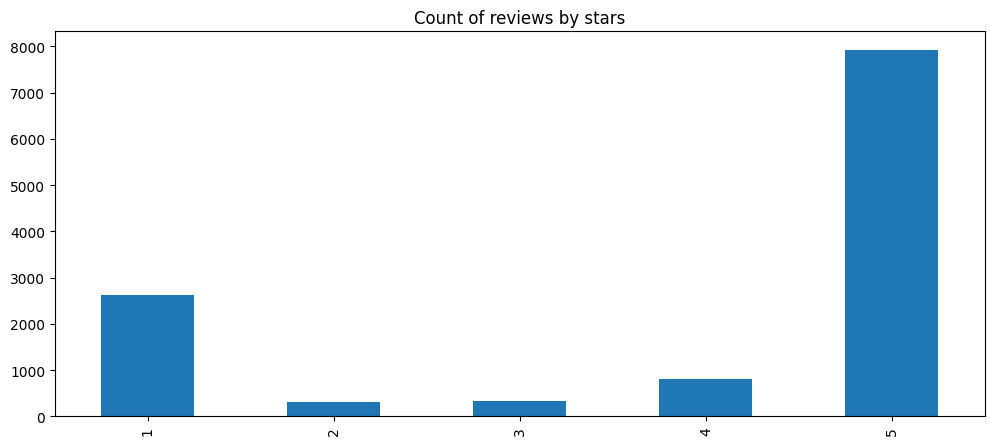

In [4]:
df['score'].value_counts().sort_index().plot(kind = 'bar', title = 'Count of reviews by stars',figsize= (12,5))

In [5]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Prasanna Sai
[nltk_data]     Chandra\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [7]:
sia = SentimentIntensityAnalyzer()

In [8]:
sia.polarity_scores("I am so happy")

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [9]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,User_0,NaN,Good,5,0,4.556.10005,2024-12-18 17:17:19,NaN,NaN,4.556.10005
1,User_1,NaN,Nice,5,0,4.556.10005,2024-12-18 17:17:17,NaN,NaN,4.556.10005
2,User_2,NaN,Very convenient,5,0,4.532.10001,2024-12-18 17:09:42,NaN,NaN,4.532.10001
3,User_3,NaN,Good,4,0,4.556.10005,2024-12-18 17:08:27,NaN,NaN,4.556.10005
4,User_4,NaN,exllence,5,0,4.556.10005,2024-12-18 17:08:16,NaN,NaN,4.556.10005


# VADER Model For Sentiment Analysis

In [10]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    content = row['content']
    userName = row['userName']
    res[userName] = sia.polarity_scores(content)

  0%|          | 0/12000 [00:00<?, ?it/s]

In [11]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'userName'})
vaders = vaders.merge(df, how='left')

In [12]:
vaders.head()

,userName,neg,neu,pos,compound,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,User_0,0.0,0.0,1.0,0.4404,NaN,Good,5,0,4.556.10005,2024-12-18 17:17:19,NaN,NaN,4.556.10005
1,User_1,0.0,0.0,1.0,0.4215,NaN,Nice,5,0,4.556.10005,2024-12-18 17:17:17,NaN,NaN,4.556.10005
2,User_2,0.0,1.0,0.0,0.0000,NaN,Very convenient,5,0,4.532.10001,2024-12-18 17:09:42,NaN,NaN,4.532.10001
3,User_3,0.0,0.0,1.0,0.4404,NaN,Good,4,0,4.556.10005,2024-12-18 17:08:27,NaN,NaN,4.556.10005
4,User_4,0.0,1.0,0.0,0.0000,NaN,exllence,5,0,4.556.10005,2024-12-18 17:08:16,NaN,NaN,4.556.10005


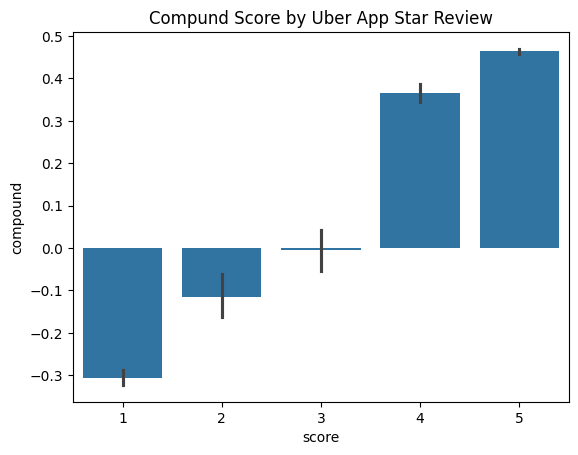

In [13]:
import seaborn as sns
ax = sns.barplot(data=vaders, x='score', y='compound')
ax.set_title('Compund Score by Uber App Star Review')
plt.show()

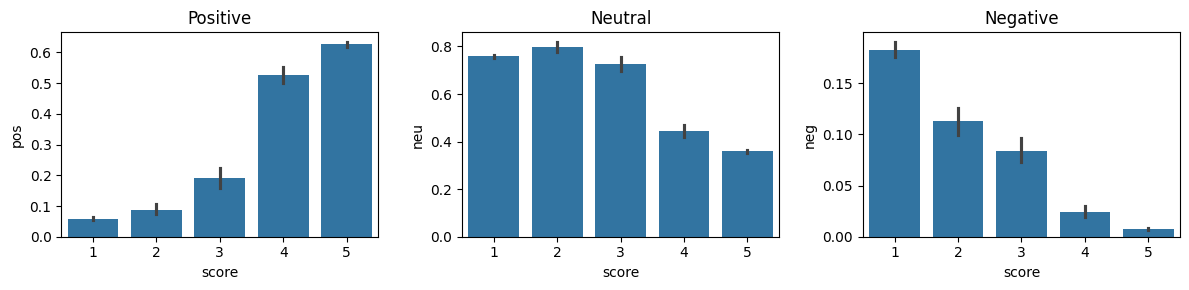

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [15]:
from transformers import pipeline
from tqdm import tqdm
import pandas as pd

# 5-class model for Sentimental Analysis

In [16]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
sent_pipeline = pipeline("sentiment-analysis", model=model_name)

In [17]:
sent_pipeline("i hate this food")

[{'label': '1 star', 'score': 0.9060118794441223}]

In [18]:
res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['content']
        myid = row['userName']
        
        pred = sent_pipeline(text)[0]   
        
        label = pred['label']           
        star = int(label[0])           
        confidence = pred['score']      

        res[myid] = {
            'bert_star': star,
            'bert_confidence': confidence
        }

    except Exception as e:
        print(f"Broke for id {myid}: {e}")


100%|████████████████████████████████████████████████████████████████████████████| 12000/12000 [13:17<00:00, 15.05it/s]


In [19]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'userName'})
results_df = results_df.merge(df, how='left', on='userName')

In [20]:
results_df.columns

Index(['userName', 'bert_star', 'bert_confidence', 'userImage', 'content',
       'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion'],
      dtype='object')

In [21]:
results_df.query('score == 1') \
    .sort_values('bert_star', ascending=False)[['content', 'bert_star', 'score','bert_confidence']].head()

,content,bert_star,score,bert_confidence
8712,Bull,5.0,1,0.440425
3180,Extra fund demand at any time ride,5.0,1,0.556808
955,OlaCabs best,5.0,1,0.673052
11124,Demand extra payment,5.0,1,0.309460
2489,Good luck even getting connected with a driver,5.0,1,0.299572


In [22]:
results_df.query('score == 5') \
    .sort_values('bert_star', ascending=True)[['content', 'bert_star', 'score','bert_confidence']].head()


,content,bert_star,score,bert_confidence
580,Exilent,1.0,5,0.580016
4358,Got the lost baggage very quickly through the app,1.0,5,0.251510
4378,Z#ssszsc😘*️⃣ ws wwwwww,1.0,5,0.246489
7904,Thak you,1.0,5,0.330450
4400,No words,1.0,5,0.576654


# Combine and compare results b/w VADER and BERT Base

In [23]:
combined_df = vaders.merge(results_df, on='userName', how='inner')

In [24]:
combined_df.head()

,userName,neg,neu,pos,compound,userImage_x,content_x,score_x,thumbsUpCount_x,reviewCreatedVersion_x,...,bert_confidence,userImage_y,content_y,score_y,thumbsUpCount_y,reviewCreatedVersion_y,at_y,replyContent_y,repliedAt_y,appVersion_y
0,User_0,0.0,0.0,1.0,0.4404,NaN,Good,5,0,4.556.10005,...,0.496963,NaN,Good,5,0,4.556.10005,2024-12-18 17:17:19,NaN,NaN,4.556.10005
1,User_1,0.0,0.0,1.0,0.4215,NaN,Nice,5,0,4.556.10005,...,0.436841,NaN,Nice,5,0,4.556.10005,2024-12-18 17:17:17,NaN,NaN,4.556.10005
2,User_2,0.0,1.0,0.0,0.0000,NaN,Very convenient,5,0,4.532.10001,...,0.627497,NaN,Very convenient,5,0,4.532.10001,2024-12-18 17:09:42,NaN,NaN,4.532.10001
3,User_3,0.0,0.0,1.0,0.4404,NaN,Good,4,0,4.556.10005,...,0.496963,NaN,Good,4,0,4.556.10005,2024-12-18 17:08:27,NaN,NaN,4.556.10005
4,User_4,0.0,1.0,0.0,0.0000,NaN,exllence,5,0,4.556.10005,...,0.302620,NaN,exllence,5,0,4.556.10005,2024-12-18 17:08:16,NaN,NaN,4.556.10005


In [25]:
combined_df[['content_x', 'compound', 'bert_star', 'bert_confidence']].head()

,content_x,compound,bert_star,bert_confidence
0,Good,0.4404,4.0,0.496963
1,Nice,0.4215,4.0,0.436841
2,Very convenient,0.0000,5.0,0.627497
3,Good,0.4404,4.0,0.496963
4,exllence,0.0000,5.0,0.302620


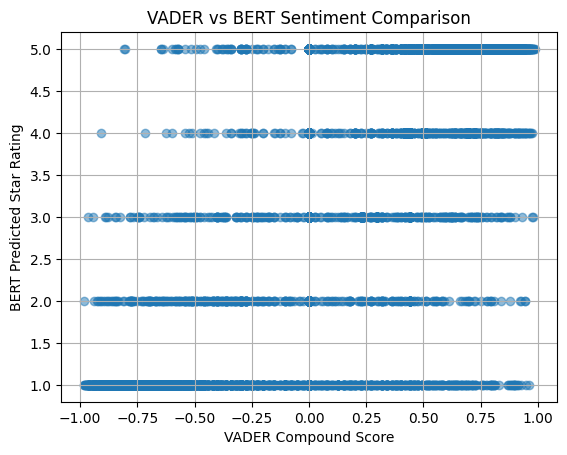

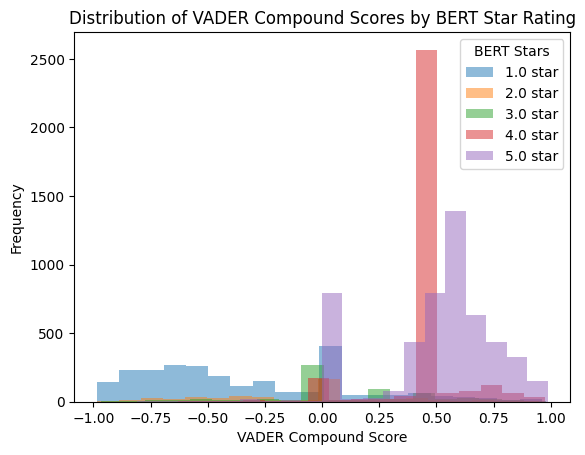

In [28]:
import matplotlib.pyplot as plt

# 1. Scatter plot: VADER compound vs BERT star rating
plt.figure()
plt.scatter(combined_df['compound'], combined_df['bert_star'], alpha=0.5)
plt.xlabel("VADER Compound Score")
plt.ylabel("BERT Predicted Star Rating")
plt.title("VADER vs BERT Sentiment Comparison")
plt.grid(True)
plt.show()

# 2. Histogram: Distribution of VADER compound scores by BERT star rating
plt.figure()
for star in sorted(combined_df['bert_star'].unique()):
    subset = combined_df[combined_df['bert_star'] == star]
    plt.hist(subset['compound'], bins=20, label=f"{star} star", alpha=0.5)
plt.xlabel("VADER Compound Score")
plt.ylabel("Frequency")
plt.title("Distribution of VADER Compound Scores by BERT Star Rating")
plt.legend(title="BERT Stars")
plt.show()


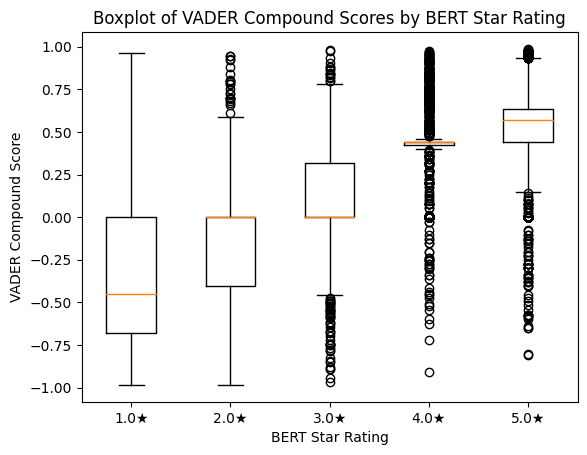

In [27]:
import matplotlib.pyplot as plt

# Prepare data for each star rating
data = [
    combined_df.loc[combined_df['bert_star'] == s, 'compound']
    for s in sorted(combined_df['bert_star'].unique())
]
labels = [f"{s}★" for s in sorted(combined_df['bert_star'].unique())]

plt.figure()
plt.boxplot(data, labels=labels)
plt.xlabel("BERT Star Rating")
plt.ylabel("VADER Compound Score")
plt.title("Boxplot of VADER Compound Scores by BERT Star Rating")
plt.show()


In [32]:
def map_star_to_3(star):
    if star <= 2: return 'neg'
    if star == 3: return 'neu'
    return 'pos'

combined_df['bert_3'] = combined_df['bert_star'].apply(map_star_to_3)
combined_df['vader_3'] = combined_df['compound'].apply(
    lambda c: 'pos' if c > 0.05 else ('neg' if c < -0.05 else 'neu')
)

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import cohen_kappa_score

print("Confusion Matrix (BERT vs VADER):")
print(confusion_matrix(combined_df['bert_3'], combined_df['vader_3']))
print(classification_report(combined_df['bert_3'], combined_df['vader_3']))
print("Cohen's Kappa:", cohen_kappa_score(combined_df['bert_3'], combined_df['vader_3']))


Confusion Matrix (BERT vs VADER):
[[1943  566  478]
 [ 115  263  284]
 [  93  956 7302]]
              precision    recall  f1-score   support

         neg       0.90      0.65      0.76      2987
         neu       0.15      0.40      0.21       662
         pos       0.91      0.87      0.89      8351

    accuracy                           0.79     12000
   macro avg       0.65      0.64      0.62     12000
weighted avg       0.86      0.79      0.82     12000

Cohen's Kappa: 0.566927719289221


In [34]:
combined_df.head()

,userName,neg,neu,pos,compound,userImage_x,content_x,score_x,thumbsUpCount_x,reviewCreatedVersion_x,...,score_y,thumbsUpCount_y,reviewCreatedVersion_y,at_y,replyContent_y,repliedAt_y,appVersion_y,bert_3,vader_3,vader_star
0,User_0,0.0,0.0,1.0,0.4404,NaN,Good,5,0,4.556.10005,...,5,0,4.556.10005,2024-12-18 17:17:19,NaN,NaN,4.556.10005,pos,pos,4
1,User_1,0.0,0.0,1.0,0.4215,NaN,Nice,5,0,4.556.10005,...,5,0,4.556.10005,2024-12-18 17:17:17,NaN,NaN,4.556.10005,pos,pos,4
2,User_2,0.0,1.0,0.0,0.0000,NaN,Very convenient,5,0,4.532.10001,...,5,0,4.532.10001,2024-12-18 17:09:42,NaN,NaN,4.532.10001,pos,neu,4
3,User_3,0.0,0.0,1.0,0.4404,NaN,Good,4,0,4.556.10005,...,4,0,4.556.10005,2024-12-18 17:08:27,NaN,NaN,4.556.10005,pos,pos,4
4,User_4,0.0,1.0,0.0,0.0000,NaN,exllence,5,0,4.556.10005,...,5,0,4.556.10005,2024-12-18 17:08:16,NaN,NaN,4.556.10005,pos,neu,4


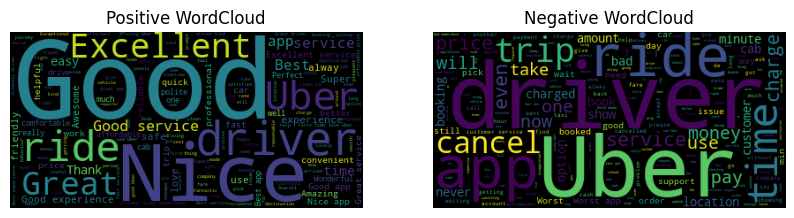

In [40]:
from wordcloud import WordCloud
pos = " ".join(combined_df[combined_df['bert_star']>=4]['content_x'])
neg = " ".join(combined_df[combined_df['bert_star']<=2]['content_x'])
wc_pos = WordCloud(width=400, height=200).generate(pos)
wc_neg = WordCloud(width=400, height=200).generate(neg)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(wc_pos); plt.axis('off'); plt.title('Positive WordCloud')
plt.subplot(1,2,2); plt.imshow(wc_neg); plt.axis('off'); plt.title('Negative WordCloud')
plt.show()

In [41]:
combined_df.to_csv('combined_df.csv', index=False)

In [42]:
pip install streamlit

   ---------------------------------------- 0.0/8.6 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/8.6 MB 6.3 MB/s eta 0:00:02
   ------------- -------------------------- 2.9/8.6 MB 7.6 MB/s eta 0:00:01
   --------------------- ------------------ 4.7/8.6 MB 7.9 MB/s eta 0:00:01
   ------------------------------ --------- 6.6/8.6 MB 8.2 MB/s eta 0:00:01
   -------------------------------------- - 8.4/8.6 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 8.6/8.6 MB 8.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/658.1 kB ? eta -:--:--
   ---------------------------------------- 658.1/658.1 kB 6.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/25.2 MB ? eta -:--:--
   -- ------------------------------------- 1.3/25.2 MB 8.4 MB/s eta 0:00:03
   ---- ----------------------------------- 2.9/25.2 MB 8.4 MB/s eta 0:00:03
   ------- -------------------------------- 4.7/25.2 MB 8.2 MB/s eta 0:00:03
   --------- ----------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orbit-ml 1.1.3 requires numpy<=1.22.2,>=1.18.2, but you have numpy 1.23.5 which is incompatible.
pooch 1.8.2 requires platformdirs>=2.5.0, but you have platformdirs 2.0.2 which is incompatible.
tensorflow-intel 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.0 which is incompatible.
